In [1]:
import os
import six
import glob
import pickle

import numpy as np
import pandas as pd

import p2pspatial
import pulse2percept.utils as p2pu

from sklearn.base import clone
import sklearn.metrics as sklm

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-04-04 00:49:45,946 [pulse2percept] [INFO] Welcome to pulse2percept


# Load data

In [2]:
def load_data(pickle_files, verbose=True):
    data = []
    for pickle_file in pickle_files:
        if verbose:
            print('- Processing %s' % pickle_file)
        y, y_pred, best_params, specifics = pickle.load(open(pickle_file, 'rb'))
        assert specifics['avg_img']
        best_cost = 0
        r2_scores = {}
        for col in y_pred.drop(columns=['electrode', 'image']).columns:
            yt = np.array(y.loc[:, col], dtype=float)
            yp = np.array(y_pred.loc[:, col], dtype=float)
            # Adjusted R squared:
            # https://stackoverflow.com/questions/42033720/python-sklearn-multiple-linear-regression-display-r-squared
            # I think yt.shape[1] is wrong - it should be X.shape[1] so the number of vars to compute df
            # And we don't know this
#             r2_scores['r2_' + col] = 1 - (1-sklm.r2_score(yt, np.nan_to_num(yp)))*(len(yt)-1)/(len(yt)-yt.shape[1]-1)
            if col == 'orientation':
                # circular error
                err = np.abs(yt - np.nan_to_num(yp))
                err = np.where(err > np.pi / 2, np.pi - err, err)
                ss_res = np.sum(err ** 2)
                ss_tot = np.sum((yt - np.mean(yt)) ** 2)
                r2_scores['r2_orientation'] = 1 - ss_res / ss_tot
            else:
                r2_scores['r2_' + col] = sklm.r2_score(yt, np.nan_to_num(yp))
            l = 1 - r2_scores['r2_' + col]
            best_cost += 2 if np.isnan(l) else l
        row = {
            'subject': specifics['subject'],
            'model': specifics['modelname'],
            'exetime': specifics['exetime'],
            'adjust_bias': specifics['adjust_bias'],
#             'best_params': best_params,
            'best_cost': best_cost,# if 'best_score' not in specifics else specifics['best_score'],
            'n_samples': len(yt),
            'filepath': os.path.dirname(pickle_file),
            'filename': os.path.basename(pickle_file)
        }
        row.update(best_params)
        row.update(r2_scores)
        data.append(row)
    return pd.DataFrame(data)

In [3]:
results_dir = '../../results/shapefit/'
pickle_files = np.sort(glob.glob(os.path.join(results_dir, '*.pickle')))
print('Found', len(pickle_files), 'files')

Found 129 files


In [4]:
subjects = ['12-005', '51-009', '52-001', 'TB']
models = ['A', 'C', 'D2', 'E2', 'F2']
assert_params = {
    'amplitude': 2.0,
}
rootfolder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape')

In [5]:
data = load_data(pickle_files, verbose=False)
data

,adjust_bias,axlambda,best_cost,exetime,filename,filepath,implant_rot,implant_x,implant_y,loc_od_x,loc_od_y,model,n_samples,r2_area,r2_compactness,r2_eccentricity,r2_orientation,rho,subject
0,False,NaN,10.009429,137.855020,12-005-A-shapefit-swarm_2018-04-01_22-07-02.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-4.370966,-0.534013,-0.809130,-0.295320,65.297402,12-005
1,True,NaN,8.442371,120.758101,12-005-A-shapefit-swarm_2018-04-01_22-51-31.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-3.429565,-0.554617,-0.364652,-0.093537,57.179828,12-005
2,False,NaN,10.413765,82.775182,12-005-A-shapefit-swarm_2018-04-03_00-13-35.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-4.417513,-1.289225,-0.327538,-0.379490,57.303894,12-005
3,True,NaN,7.909688,128.109772,12-005-A-shapefit-swarm_2018-04-03_00-31-50.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-2.620624,-0.679451,-0.387533,-0.222081,62.726189,12-005
4,False,NaN,10.578116,124.875039,12-005-A-shapefit-swarm_2018-04-03_06-42-39.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-4.385011,-0.933562,-0.887193,-0.372350,65.435664,12-005
5,True,NaN,8.649639,103.570537,12-005-A-shapefit-swarm_2018-04-03_07-17-42.pi...,../../results/shapefit,NaN,NaN,NaN,NaN,NaN,A,22,-2.617369,-0.652354,-1.222162,-0.157754,65.581219,12-005
6,False,NaN,5.351718,263.436795,12-005-B-shapefit-swarm_2018-04-01_22-35-11.pi...,../../results/shapefit,-0.387325,365.635811,-451.128982,NaN,NaN,B,22,-0.220306,-0.438097,-0.710613,0.017298,525.958714,12-005
7,True,NaN,5.319741,536.132694,12-005-B-shapefit-swarm_2018-04-01_23-14-42.pi...,../../results/shapefit,-0.349804,311.142373,162.501707,NaN,NaN,B,22,-0.008720,-0.454338,-0.744421,-0.112262,766.811633,12-005
8,False,NaN,6.513250,61.078370,12-005-B-shapefit-swarm_2018-04-03_00-23-08.pi...,../../results/shapefit,-0.245892,756.596773,-660.317250,NaN,NaN,B,22,-0.798062,-0.718075,-0.932485,-0.064627,645.089287,12-005
9,True,NaN,6.015249,194.634266,12-005-B-shapefit-swarm_2018-04-03_00-38-06.pi...,../../results/shapefit,-0.002698,209.221181,-251.165036,NaN,NaN,B,22,0.107847,-0.588186,-1.254766,-0.280144,776.670382,12-005


In [6]:
data.n_samples.unique()

array([22, 18, 28, 12])

# All runs

In [7]:
# Group by these:
groupcols = ['subject', 'model', 'adjust_bias']
# Don't show these:
extracols = ['filepath', 'exetime', 'n_samples', 'filename']
paramcols = ['rho', 'axlambda', 'implant_x', 'implant_y', 'implant_rot', 'loc_od_x', 'loc_od_y']
r2cols = ['r2_area', 'r2_orientation', 'r2_eccentricity', 'r2_compactness']

In [8]:
data.groupby(groupcols)['exetime'].agg(['mean', 'count'])

mean  count
subject model adjust_bias                     
12-005  A     False          115.168414      3
              True           117.479470      3
        B     False          204.319478      3
              True           308.337049      3
        C     False        10564.804656      2
              True          6205.779413      4
        D     False        11444.777542      5
              True          8725.757020      8
51-009  A     False          609.658653      3
              True           384.785437      3
        B     False          299.491796      3
              True           424.402255      3
        C     False        12296.192156      4
              True         15107.493226      3
        D     False        20562.787287      5
              True         16924.480597      3
52-001  A     False          320.777663      3
              True           189.022383      3
        B     False          205.867552      3
              True           446.620208      3
        C     False        12251.508453      3
              True         12607.538087      9
        D     False        10214.498145      9
              True         12651.916925      5
TB      A     False           89.905038      3
              True            73.748509      3
        B     False           89.765512      3
              True            53.049237      2
        C     False         9913.880833      4
              True         14200.725603      5
        D     False        10756.355404      6
              True         10293.676942      7

# PSO results vary a lot from run to run

In [9]:
data.drop(columns=extracols + r2cols + ['best_cost']).groupby(groupcols).agg(['mean', 'std'])

axlambda              implant_rot            \
                                  mean          std        mean       std   
subject model adjust_bias                                                   
12-005  A     False                NaN          NaN         NaN       NaN   
              True                 NaN          NaN         NaN       NaN   
        B     False                NaN          NaN   -0.228520  0.168166   
              True                 NaN          NaN   -0.287980  0.259944   
        C     False        1483.681505  1611.570145   -0.667708  0.050468   
              True         2009.089356   885.858614   -0.468995  0.184813   
        D     False         561.832679   661.089247   -0.407893  0.338509   
              True         1438.531345   884.870744   -0.504992  0.276337   
51-009  A     False                NaN          NaN         NaN       NaN   
              True                 NaN          NaN         NaN       NaN   
        B     False                NaN          NaN   -0.239015  0.226342   
              True                 NaN          NaN   -0.365676  0.089308   
        C     False        1539.045871   545.864653   -0.465694  0.122707   
              True         2055.672438   435.412119   -0.439744  0.105808   
        D     False        1433.199497   759.998710   -0.490265  0.186151   
              True         1323.742470   814.881496   -0.209797  0.149175   
52-001  A     False                NaN          NaN         NaN       NaN   
              True                 NaN          NaN         NaN       NaN   
        B     False                NaN          NaN   -0.279568  0.339347   
              True                 NaN          NaN   -0.285709  0.111364   
        C     False         528.472330   266.817277   -0.371511  0.176995   
              True         1063.285439   910.513092   -0.419485  0.214852   
        D     False        1043.987842   690.119412   -0.163193  0.181980   
              True         1273.789371   863.007404   -0.160788  0.224597   
TB      A     False                NaN          NaN         NaN       NaN   
              True                 NaN          NaN         NaN       NaN   
        B     False                NaN          NaN   -0.655148  0.162174   
              True                 NaN          NaN   -0.357722  0.083386   
        C     False        2221.355415   427.061152   -0.667995  0.086751   
              True         1519.085070   834.121544   -0.632297  0.184912   
        D     False        1823.635925   809.630821   -0.630933  0.155277   
              True         1718.632377   792.673452   -0.609949  0.184813   

                             implant_x                implant_y              \
                                  mean          std        mean         std   
subject model adjust_bias                                                     
12-005  A     False                NaN          NaN         NaN         NaN   
              True                 NaN          NaN         NaN         NaN   
        B     False         473.172717   247.820167 -360.636674  353.717532   
              True          226.943727    76.884890  -71.667122  212.183235   
        C     False       -1105.652155   216.311243  656.227251  154.553221   
              True        -1228.566303   395.402510  328.095366  354.748689   
        D     False       -1565.714133   656.879320  349.679142  214.562006   
              True        -1762.145905   221.487879  219.055186  327.476477   
51-009  A     False                NaN          NaN         NaN         NaN   
              True                 NaN          NaN         NaN         NaN   
        B     False         287.539577    60.417033 -303.629244  101.218714   
              True          331.715472    67.359474 -375.601957   40.889252   
        C     False        -538.101893   467.299713 -301.949916  161.905359   
              True         -840.623550   205.076984 -226.364138   79.1

# The best runs in their respective category

In [10]:
print('Best scores:')
# Find the rows that have the best score in their subject/model/bias group:
best_idx = data.groupby(groupcols)['best_cost'].transform(np.min) == data['best_cost']
data.loc[best_idx, :].drop(columns=extracols + paramcols).groupby(groupcols).max()

Best scores:


best_cost   r2_area  r2_compactness  \
subject model adjust_bias                                        
12-005  A     False        10.009429 -4.370966       -0.534013   
              True          7.909688 -2.620624       -0.679451   
        B     False         5.351718 -0.220306       -0.438097   
              True          5.319741 -0.008720       -0.454338   
        C     False         6.185584 -1.008613       -0.288629   
              True          4.921864  0.172582       -0.323495   
        D     False         5.776738 -0.839609       -0.416898   
              True          3.757743  0.185496       -0.198089   
51-009  A     False        60.334971 -1.277026       -2.490554   
              True         35.853796 -1.745322       -2.081840   
        B     False        24.527517 -0.004522       -2.308254   
              True         14.710681  0.007064       -1.716469   
        C     False         2.627675  0.180885       -0.083782   
              True          1.995548  0.400923        0.110059   
        D     False         2.671727  0.202968        0.204977   
              True          3.438880 -0.034327       -0.205352   
52-001  A     False        10.425541 -3.874011       -0.187253   
              True         14.565295 -3.869254       -0.201593   
        B     False         5.289369 -0.063161       -0.185708   
              True          7.203004  0.023619       -0.191053   
        C     False         4.056012 -0.022520       -0.163103   
              True          4.079056 -0.452970       -0.165553   
        D     False         4.109351 -0.135065       -0.167007   
              True          4.196334 -0.444473       -0.157247   
TB      A     False        59.015756 -2.002268       -3.803580   
              True         52.813327 -2.573659       -3.702643   
        B     False        13.345437 -1.910720       -2.058196   
              True         17.659398 -3.047094       -3.168548   
        C     False         4.305373 -0.263303       -0.292000   
              True          3.233882 -0.612178        0.181732   
        D     False         4.679514 -0.415061       -0.304175   
              True          4.069160 -0.949552       -0.014853   

                           r2_eccentricity  r2_orientation  
subject model adjust_bias                                   
12-005  A     False              -0.809130       -0.295320  
              True               -0.387533       -0.222081  
        B     False              -0.710613        0.017298  
              True               -0.744421       -0.112262  
        C     False              -1.042776        0.154434  
              True               -0.909447        0.138496  
        D     False              -0.765037        0.244806  
              True               -0.087675        0.342525  
51-009  A     False             -52.874134        0.306743  
              True              -28.357135        0.330502  
        B     False             -18.503881        0.289140  
              True               -9.382286        0.381010  
        C     False               0.600869        0.674353  
              True                0.867884        0.625587  
        D     False               0.249355        0.670974  
              True                0.428709        0.372090  
52-001  A     False              -2.736163        0.371886  
              True               -6.688977        0.194529  
        B     False              -1.350379        0.309879  
              True               -3.359232        0.323662  
        C     False              -0.190638        0.320250  
              True                0.090770        0.448698  
        D     False               0.039425        0.153295  
              True                0.112416        0.292970  
TB      A     False             -46.874909       -2.334999  
              True              -39.943237       -2.593787  
        B     False              -4.645898       -0.730623  
             

# Runs that give sufficiently good results

In [11]:
best_runs = data.loc[best_idx, :]
done_idx = (best_runs['r2_area'] > 0.01) & (best_runs['r2_orientation'] > 0.01)
# done_idx &= (best_runs['r2_eccentricity'] > 0) & (best_runs['r2_compactness'] > 0)

In [12]:
best_runs.loc[done_idx, :].drop(columns=extracols[:-1] + paramcols).groupby(groupcols).max()

best_cost  \
subject model adjust_bias              
12-005  C     True          4.921864   
        D     True          3.757743   
51-009  C     False         2.627675   
              True          1.995548   
        D     False         2.671727   
52-001  B     True          7.203004   

                                                                    filename  \
subject model adjust_bias                                                      
12-005  C     True         12-005-C-shapefit-swarm_2018-04-03_12-15-41.pi...   
        D     True         12-005-D-shapefit-swarm_2018-04-04_01-43-21.pi...   
51-009  C     False        51-009-C-shapefit-swarm_2018-04-03_00-06-26.pi...   
              True         51-009-C-shapefit-swarm_2018-04-02_23-03-08.pi...   
        D     False        51-009-D-shapefit-swarm_2018-04-02_17-07-49.pi...   
52-001  B     True         52-001-B-shapefit-swarm_2018-04-01_23-24-03.pi...   

                            r2_area  r2_compactness  r2_eccentricity  \
subject model adjust_bias                                              
12-005  C     True         0.172582       -0.323495        -0.909447   
        D     True         0.185496       -0.198089        -0.087675   
51-009  C     False        0.180885       -0.083782         0.600869   
              True         0.400923        0.110059         0.867884   
        D     False        0.202968        0.204977         0.249355   
52-001  B     True         0.023619       -0.191053        -3.359232   

                           r2_orientation  
subject model adjust_bias                  
12-005  C     True               0.138496  
        D     True               0.342525  
51-009  C     False              0.674353  
              True               0.625587  
        D     False              0.670974  
52-001  B     True               0.323662

In [13]:
plot_files = best_runs.loc[done_idx, :].reset_index()

In [14]:
y, _, _, _ = pickle.load(open(os.path.join(*plot_files.loc[0, ['filepath', 'filename']]), 'rb'))
columns = y.drop(columns=['electrode', 'image']).columns

# Plot best ones

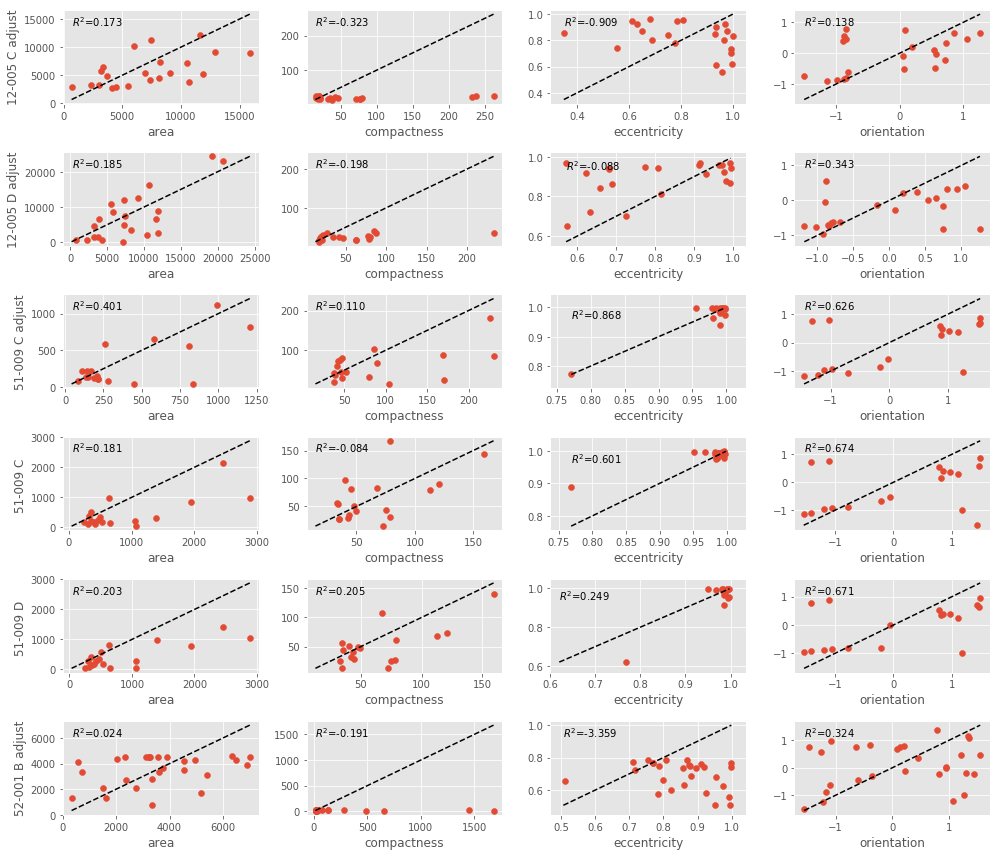

In [15]:
fig, axes = plt.subplots(ncols=len(columns), nrows=len(plot_files), figsize=(14, 2 * len(plot_files)))
for (_, row), axrow in zip(plot_files.iterrows(), axes):
    y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))
    for col, ax in zip(columns, axrow):
        ax.scatter(y[col], y_pred[col])
        minval = np.minimum(y[col].min(), y_pred[col].min())
        maxval = np.maximum(y[col].max(), y_pred[col].max())
        ax.plot([minval, maxval], [minval, maxval], 'k--')
        ax.set_xlabel(col)
        ax.text(minval, maxval, "$R^2$=%.3f" % float(row['r2_' + col]), va='top')
    axrow[0].set_ylabel('%s %s %s' % (row['subject'], row['model'],
                                      "adjust" if row['adjust_bias'] else ""))
fig.tight_layout()

In [16]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

In [17]:
y, y_pred, _, _ = pickle.load(open(os.path.join(*row[['filepath', 'filename']]), 'rb'))

In [18]:
for col in columns:
    df = pd.DataFrame({'y': y[col], 'y_hat': y_pred[col]})
    model = ols('y ~ y_hat', data=df).fit()
    anovaResults = anova_lm(model)
    print('')
    print(col)
    print(anovaResults)


area
            df        sum_sq       mean_sq         F    PR(>F)
y_hat      1.0  1.073300e+07  1.073300e+07  3.490107  0.073046
Residual  26.0  7.995687e+07  3.075264e+06       NaN       NaN

compactness
            df        sum_sq        mean_sq        F    PR(>F)
y_hat      1.0  6.996982e+05  699698.153338  4.55877  0.042341
Residual  26.0  3.990583e+06  153483.969360      NaN       NaN

eccentricity
            df    sum_sq   mean_sq         F    PR(>F)
y_hat      1.0  0.025347  0.025347  2.192375  0.150713
Residual  26.0  0.300599  0.011561       NaN       NaN

orientation
            df    sum_sq   mean_sq         F    PR(>F)
y_hat      1.0   1.09449  1.094490  1.010238  0.324109
Residual  26.0  28.16837  1.083399       NaN       NaN


/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/home/mbeyeler/anaconda3/lib/python3.5/site-packages/scipy/stats/_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
